In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('../data.csv')
df.shape


(288, 7)

In [3]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [4]:
# df_before =df.iloc[:144, :]


# indexes = np.array_split(df_before.index,8, axis=0)
# for i,index in enumerate(indexes):
#     df_before.loc[index,'group'] = i
    
# df_before['c'] = df_before['group'].diff()
# df_filtered = df_before[df_before['c'] != 0]

# index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# # print(len(index_list))
# # print('\n')
# # print(index_list)

# l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
# list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# # len(list_of_dfs)

In [5]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()
# data_split_modified_z_12 = data_split_modified_z.to_numpy()


# """ SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 16)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)

# data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [6]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
#                 print(test_data)
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                print(max_score)
                return int(i[0])
    else:
        return n_clusters_min

In [7]:
def combine_dfs(df_list):
    return pd.concat(df_list)

---
# THESHOLD 0.01

0.6091172651247094
0.6149486881323344
0.6007216178814435
0.6829409472302396
0.6945825468436286
0.7057381514441371
0.6691842955293017
0.6854185317459947


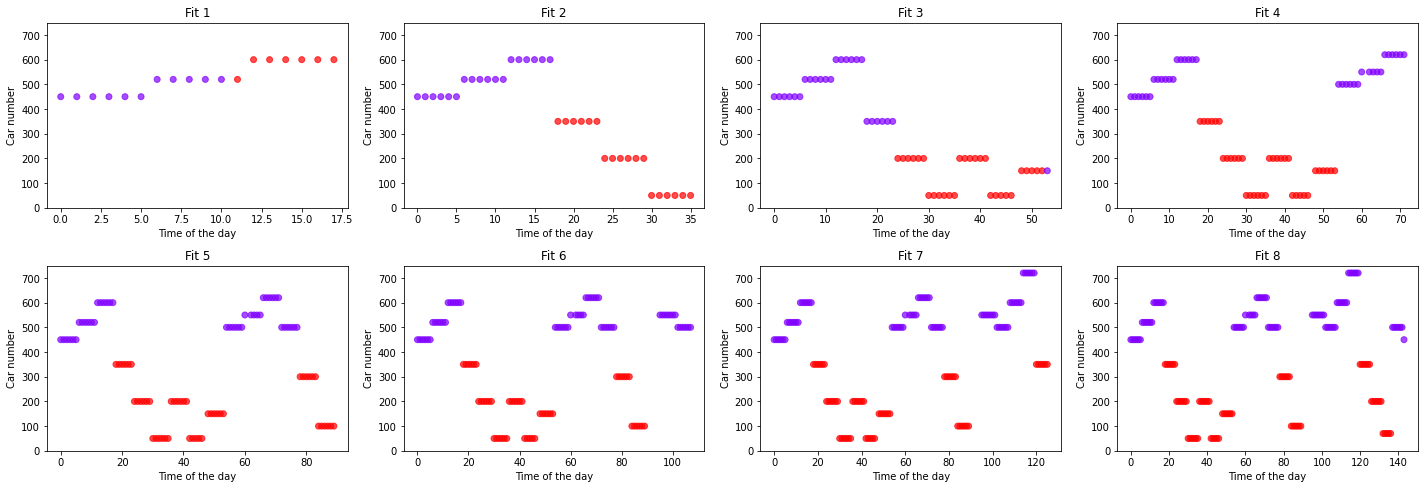

In [8]:
model_001_before= Birch(n_clusters=None, threshold=0.01)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[:8]:
    
    model_001_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_001_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [9]:
# data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[144:, :]
# data_split_modified_z = data_split_modified_z.to_numpy()
# data_split_modified_z_12 = np.split(data_split_modified_z, 8)


0.604544722976592
0.616362717473665
0.6610855712582258
0.6756338789915889
0.6733046463440022
0.6826356192650395
0.6548952094151755
0.6454569735546909


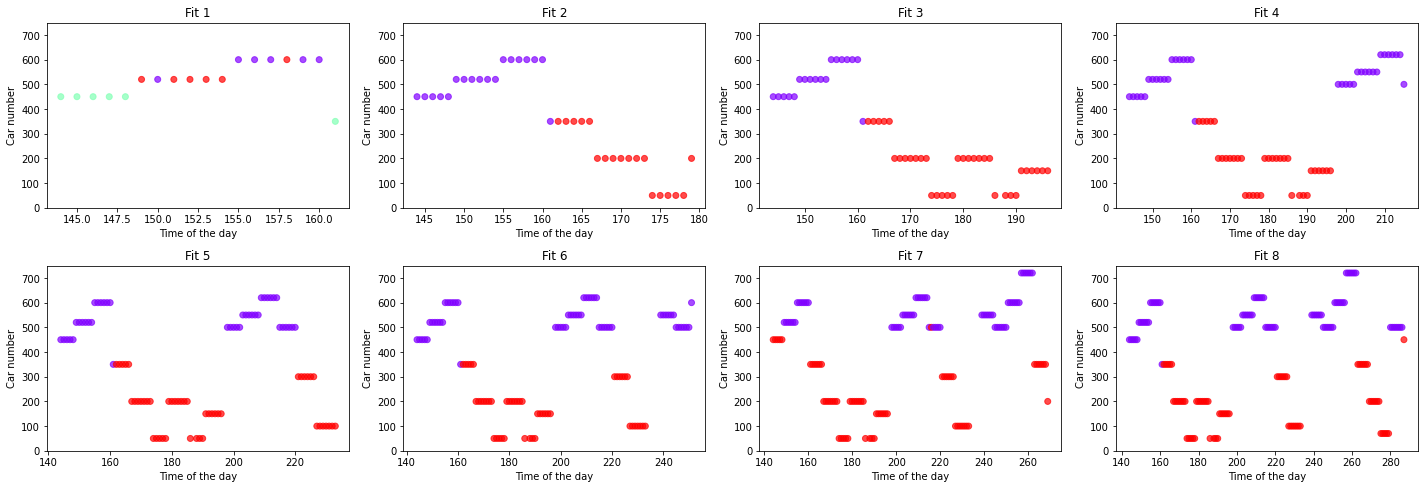

In [10]:
model_001_before= Birch(n_clusters=None, threshold=0.01)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_001_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_001_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

---
# THESHOLD 0.05

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (7) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


0.6091172651247094
0.5756143041977831
0.6007216178814435
0.6104685789823832
0.6945825468436286
0.7057381514441371
0.5102141870442944
0.5792174632326612


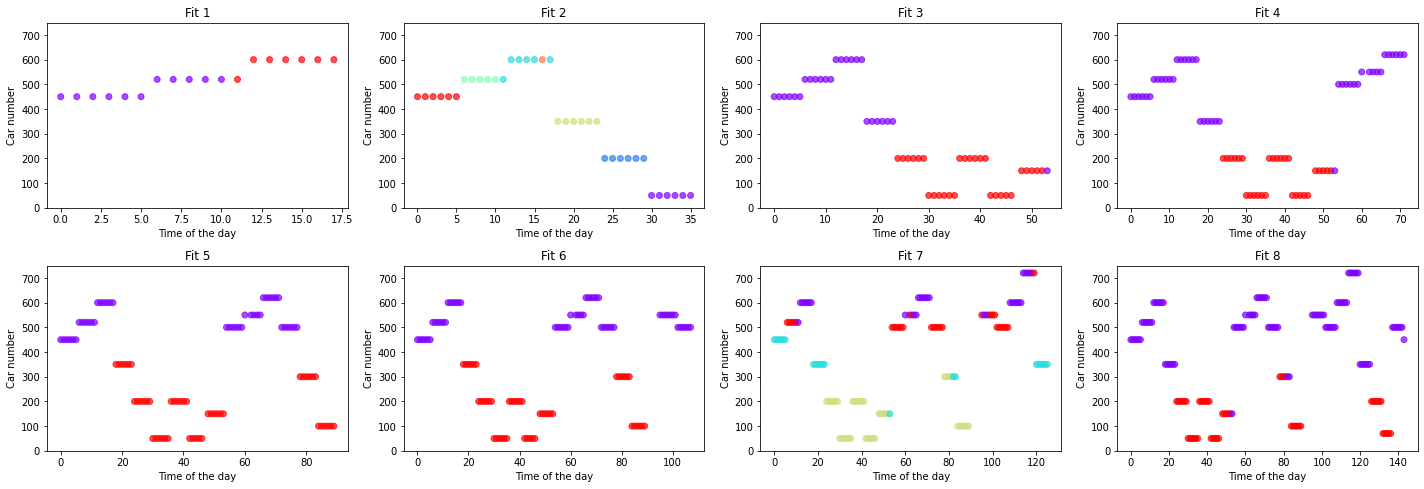

In [11]:
model_005_before= Birch(n_clusters=None, threshold=0.05)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[:8]:
    
    model_005_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (8) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (8) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


0.604544722976592
0.616362717473665
0.6610855712582258
0.6756338789915889
0.6733046463440022
0.6826356192650395
0.6575174050948737
0.4927953831211868


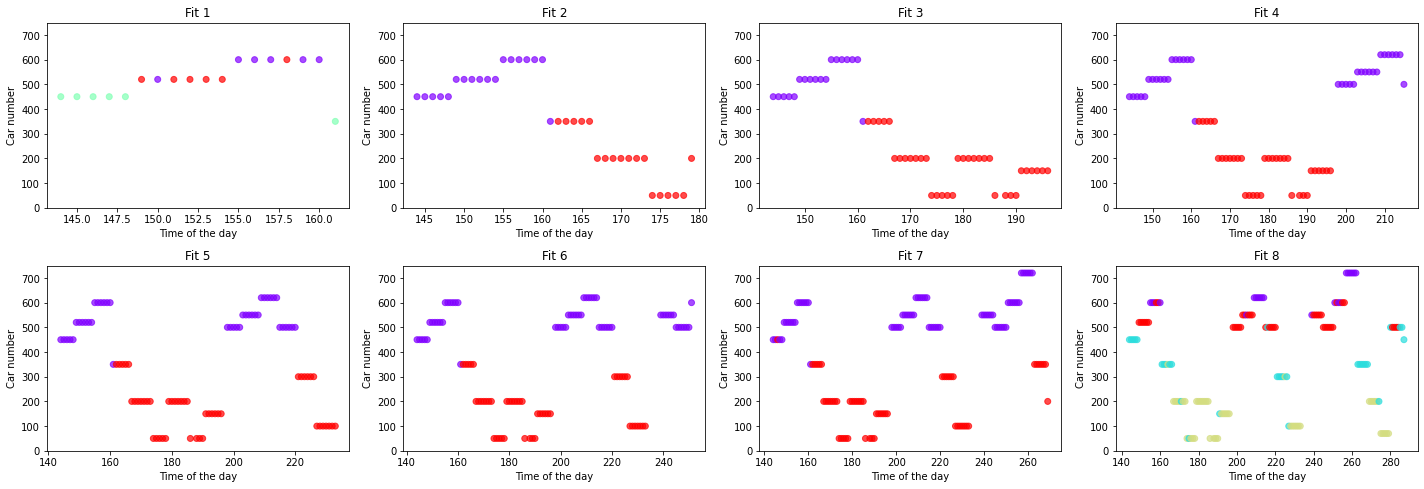

In [12]:
model_005_before= Birch(n_clusters=None, threshold=0.05)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_005_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

---
# THRESHOLD 0.1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (4) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.5806699262398651
0.6149486881323344
0.6017948350045569
0.5926914777621699
0.6945825468436286
0.7057381514441371
0.6691842955293017
0.6854185317459947


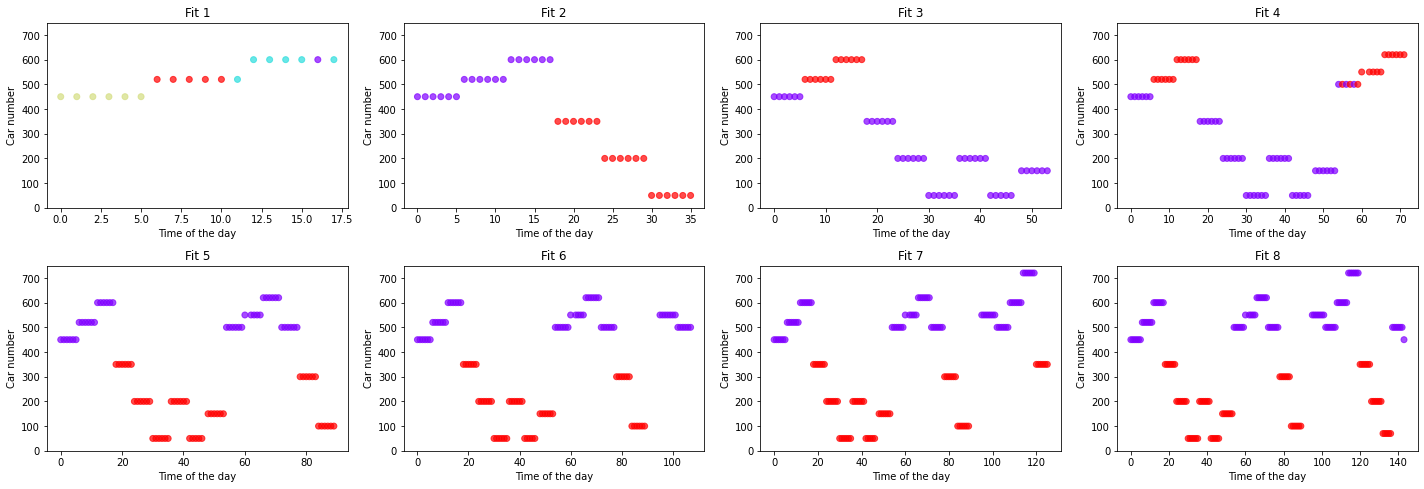

In [13]:
model_01_before= Birch(n_clusters=None, threshold=0.1)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[:8]:
    
    model_01_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_01_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.5755758607320741
0.616362717473665
0.6387597795444407
0.6705172014876344
0.6733046463440022
0.6826356192650395
0.648516322294552
0.6264381580722319


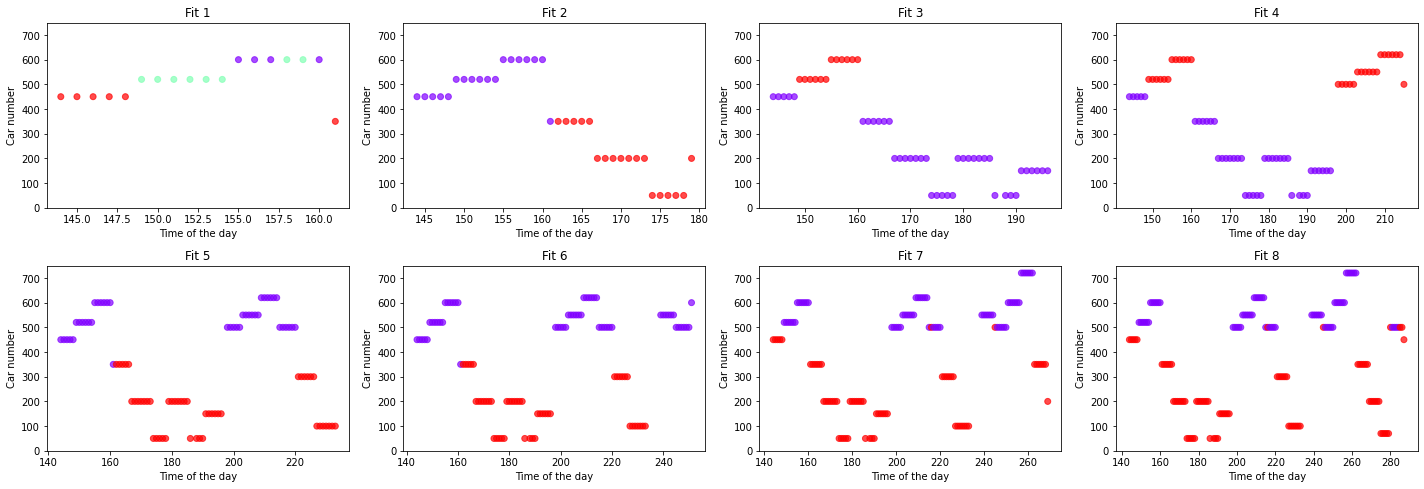

In [14]:
model_01_before= Birch(n_clusters=None, threshold=0.1)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_01_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_01_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

---
# THRESHOLD 0.2

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.44406632019158676
0.6149486881323344
0.6668170024851792
0.6829409472302396
0.6945825468436286
0.7057381514441371
0.6691842955293017
0.6854185317459947


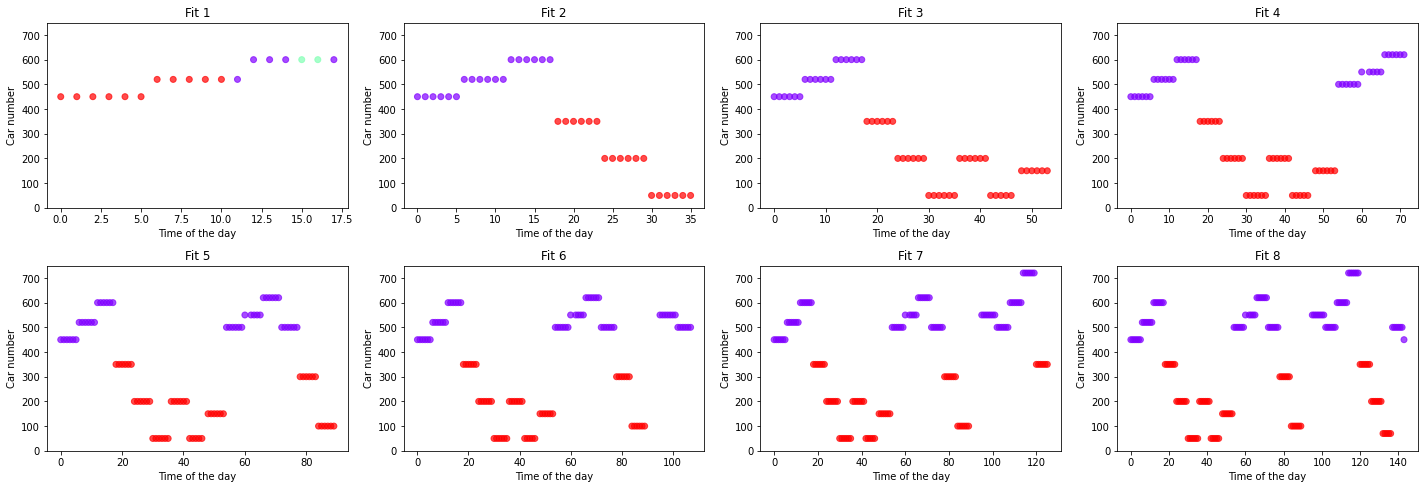

In [15]:
model_02_before= Birch(n_clusters=None, threshold=0.2)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[:8]:
    
    model_02_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.48358643291687575
0.616362717473665
0.6193127829461017
0.6528141561997259
0.6347256127340501
0.6041519980315986
0.5959524820918988
0.5982243926909534


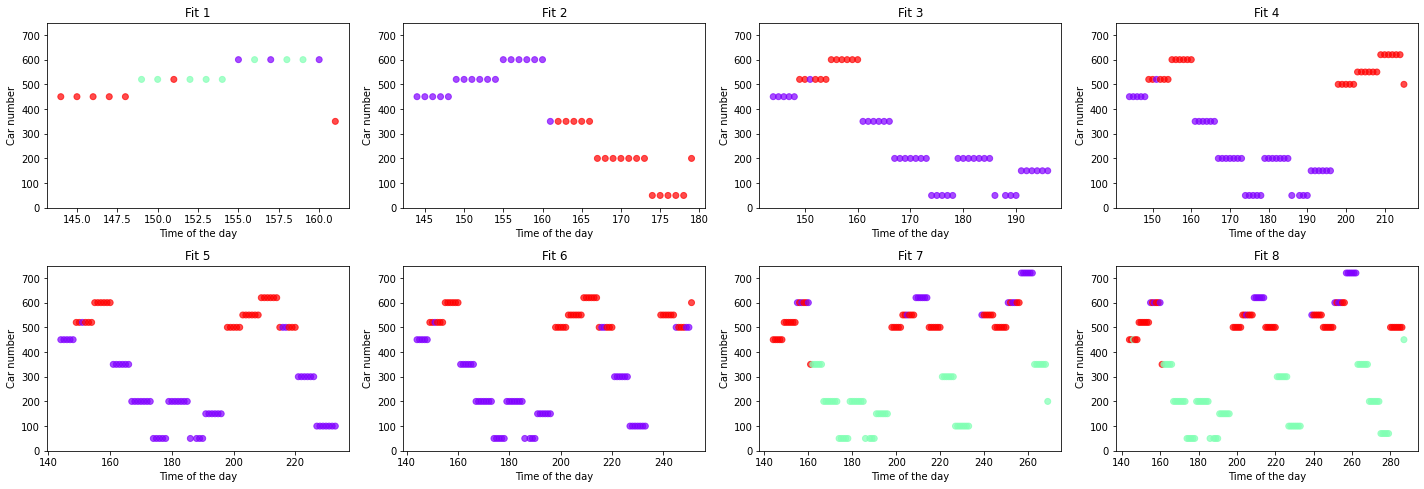

In [16]:
model_02_before= Birch(n_clusters=None, threshold=0.2)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_02_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (2) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.616362717473665
0.6610855712582258
0.6770669162081364
0.6753472454099151
0.6836923490359161
0.6575174050948737
0.6477376522626559


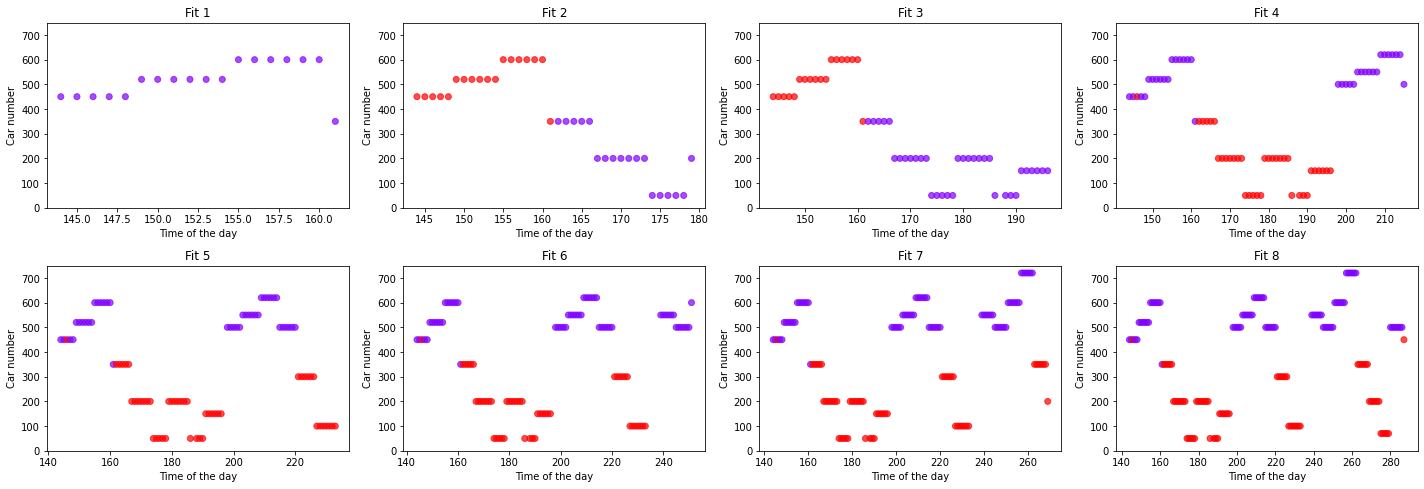

In [17]:
model_02_before= Birch(n_clusters=None, threshold=0.3)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_02_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (2). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

0.552371220376566
0.6201961104716439
0.6159246954982982
0.6100754818973216
0.5737855890660558


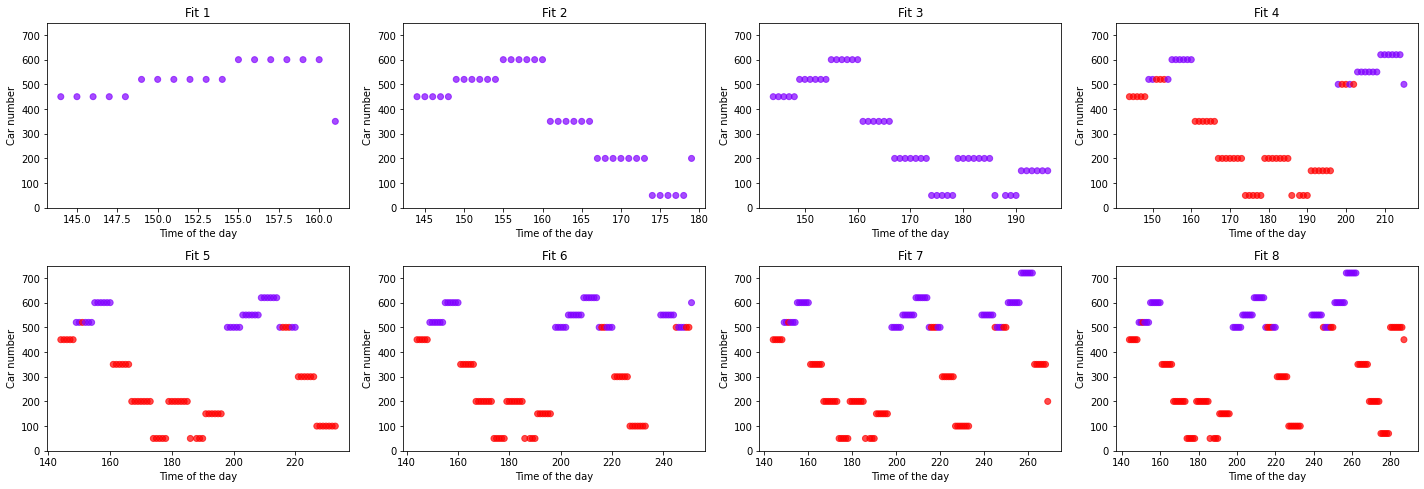

In [18]:
model_02_before= Birch(n_clusters=None, threshold=0.5)

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1


for i in data_split_modified_z_12[8:]:
    
    model_02_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
#     if fit_number >= 9:
#         axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1